# Exercise 6

In [1]:
import numpy as np
import scipy.sparse
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
%matplotlib inline

In [2]:
plt.gray()

<Figure size 432x288 with 0 Axes>

<span style ="color:green;font-weight:bold ">Comments:  
    - For exercise 2) Bias and variance of ridge regression \
    - We used the exactly the same approach and also got to the right solution, on the way we computed moreadditional steps\
    - all in all no much difference betweeenboth solutions. \
     </span >

### 3 Denoising of a CT image

In [3]:
# take function from sample solution ad modify it 

def makeA(shape, alphas, K = None, tau = 0):
    N = shape[0]
    # Define the sensorsize K
    if K is None:
        K = int(np.sqrt(2) * N)
        if K % 2 == 0:
            K += 1
            
    # Create regularization matrix
    reg = np.sqrt(tau)*scipy.sparse.identity(N*N)
    # Create the empty sparse A
    A = scipy.sparse.dok_matrix((N*N, len(alphas)*K))
    # Fill it
    for i, alpha in enumerate(alphas):
        alph_rad = np.radians(alpha)
        rot_mat = np.array([[np.cos(alph_rad), -np.sin(alph_rad)],
                            [np.sin(alph_rad), np.cos(alph_rad)]])
        
        for y in range(N):
            for x in range(N):
                # Center the coordinates and rotate them
                p = x - (N-1) / 2.0
                q = y - (N-1) / 2.0
                p,q = rot_mat.dot([p,q])
                pos = p + (K-1)/2.
                
                # Find the two neighboring bins
                bin0 = int(np.floor(pos))
                bin1 = int(np.ceil(pos))
                
                # Updating A
                if bin0 == bin1:
                    A[y*N + x, i*K + bin0] = 1.0
                else:
                    val0 = bin1 - pos
                    val1 = pos - bin0
                    
                    if bin1 == 0:
                        A[y*N + x, i*K] = val1
                    elif bin0 == K-1:
                        A[y*N + x, i*K + bin0] = val0
                    else:
                        A[y*N + x, i*K + bin0] = val0
                        A[y*N + x, i*K + bin1] = val1
                        
    # Stack together A and regularization 
    X = scipy.sparse.vstack([A.T, reg])
    return X

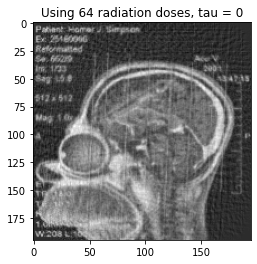

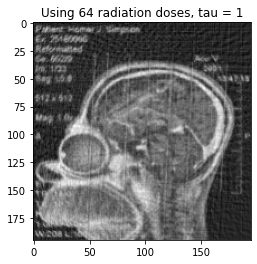

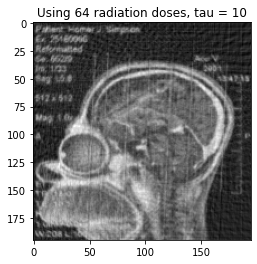

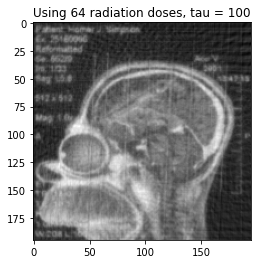

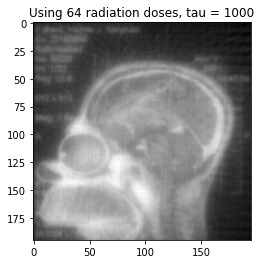

In [4]:
# reconstruction
K = 275
alphas_large = np.load("../sheet7/hs_tomography/alphas_195.npy")
y_large = np.load("../sheet7/hs_tomography/y_195.npy")
tau = [ 0 , 1, 10, 100, 1000]
nr_doses = [64]
for pltnr, dose in enumerate(nr_doses):
    for t in tau:
        M = 195
        D = M*M
        index = [int(np.ceil(i*len(alphas_large)/float(dose))) for i in range(dose)]
        alphas_sub = alphas_large[index]
        y_sub = np.zeros((dose*K + D))
        for i,j in enumerate(index):
            y_sub[i*K:(i+1)*K] = y_large[j*K:(j+1)*K]
        A = makeA((M,M), alphas_sub, K, tau = t).tocsc()
        x = lsqr(A, y_sub)
        plt.figure()
        plt.imshow(x[0].reshape(M,M))
        plt.title(f'Using {dose} radiation doses, tau = {t}')
        #plt.savefig("large_%d.png" %dose)

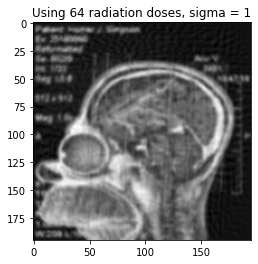

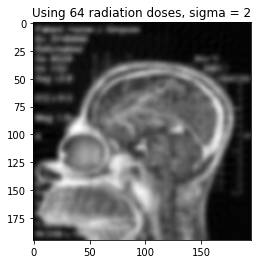

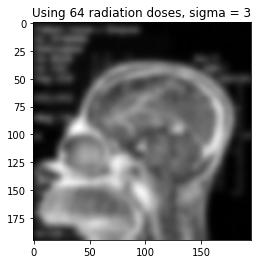

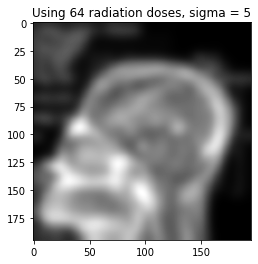

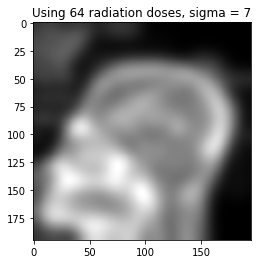

In [5]:
# Use Gaussian filter kernel approach: 
sigma = [1 , 2,3,5,7]

for pltnr, dose in enumerate(nr_doses):
    for sig in sigma:
        M = 195
        D = M*M
        index = [int(np.ceil(i*len(alphas_large)/float(dose))) for i in range(dose)]
        alphas_sub = alphas_large[index]
        y_sub = np.zeros((dose*K + D))
        for i,j in enumerate(index):
            y_sub[i*K:(i+1)*K] = y_large[j*K:(j+1)*K]
        A = makeA((M,M), alphas_sub, K).tocsc()
        x = lsqr(A, y_sub)
        img = x[0].reshape(M,M)
        img = gaussian_filter(img, sig) 
        plt.figure()
        plt.imshow(img)
        plt.title(f'Using {dose} radiation doses, sigma = {sig}')
        #plt.savefig("large_%d.png" %dose)

<span style ="color:green;font-weight:bold ">Comments:  
    - First it is of cause way more efficient to use a vectorized method to calculate the X matrix as done in the sample solution. \
    - I didnt comment much on the results but neither did the sample soultion , however this could be improved \
    - Furthermore it is not necessary to make a loop over the radiation angles, as I only look at one. 
     </span >

### 4 Automatic feature selection for regression

#### 4.1 Implement Orthogonal Matching Pursuit

In [ ]:
def omp_regression(X, y, T):
    # Initilize
    D = X.shape[1]
    A = []
    B = np.ones((D)) 
    r = y
    
    # Update
    beta = np.zeros((T,D))
    for t in list(range(1, T)):
        j = np.argmax(B*(np.sum(X.T*r,  axis=1)))
        A.append(j)
        B[j] = 0
        X_active = X[:,A]
        beta[t] = beta[t-1]
        beta[t,j] = np.argmin((np.linalg.inv(X_active.T.dot(X_active)).dot(X_active.T.dot(y))))

        X_active = np.zeros_like(X)
        X_active[:,A] = X[:,A]
        r = y - X_active.dot(beta[t])
    return beta

In [ ]:
N = 5
D = 10
X = np.random.rand(N,D)
y = np.ones((N))
omp_regression(X, y, 5)